In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as scipy
import statsmodels.stats.multitest as multi
 

%config Completer.use_jedi = False


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
def find_nearest(a, a0):
    "Element in nd array `a` closest to the scalar value `a0`"
    idx = np.abs(a - a0).argmin()
    return a.flat[idx]

## Casein proteolytic activity S.lycopersicum

In [3]:
casein = pd.read_csv('/home/felix/thesis/chapter2_tomato_ISs/Results/1_Immuno_secretomes_of_tomatoes/casein/casein_data.csv', skiprows=1)
casein.drop([0], inplace=True)
casein.index = casein.Time_s.to_numpy()
casein.drop(columns=['Time_s'], inplace=True)

In [4]:
new = []

for row in casein.index:
    for counter, col in enumerate(casein.columns):
        if casein.loc[row, col] != 'OVER':
            if counter == 0:
                base =float(casein.loc[row, col])

            else:
                value = float(casein.loc[row, col]) - base
                treat = row[:1]

                new.append([row, treat, float(col), float(value)])
            
    
casein_A = pd.DataFrame(new, columns=['sample', 'treatment', 'time_point_s', 'RFU'])

In [5]:
time_point = float(find_nearest(casein_A.time_point_s.to_numpy(), 300))
casein_A_5min = casein_A[casein_A.time_point_s == time_point]

In [15]:
casein_A_5min

,sample,treatment,time_point_s,RFU
9,W1,W,300.1,8267.0
60,W2,W,300.1,7440.0
111,W3,W,300.1,6021.0
162,W4,W,300.1,10376.0
213,W5,W,300.1,7071.0
264,W6,W,300.1,4796.0
315,B1,B,300.1,16106.0
360,B2,B,300.1,15515.0
411,B3,B,300.1,16192.0
447,B4,B,300.1,14037.0


In [21]:
mb_comp_t, mb_comp_p = scipy.ttest_ind(casein_A_5min[casein_A_5min.treatment == 'W'].RFU.to_numpy(), casein_A_5min[casein_A_5min.treatment == 'B'].RFU.to_numpy())

In [22]:
mb_comp_p

3.789166492005806e-06

In [23]:
sl_caseinA_W = np.mean(casein_A_5min[casein_A_5min.treatment == 'W'].RFU.to_numpy())
sl_caseinA_B = np.mean(casein_A_5min[casein_A_5min.treatment == 'B'].RFU.to_numpy())

In [24]:
sl_caseinA_B/sl_caseinA_W

2.209820108708012

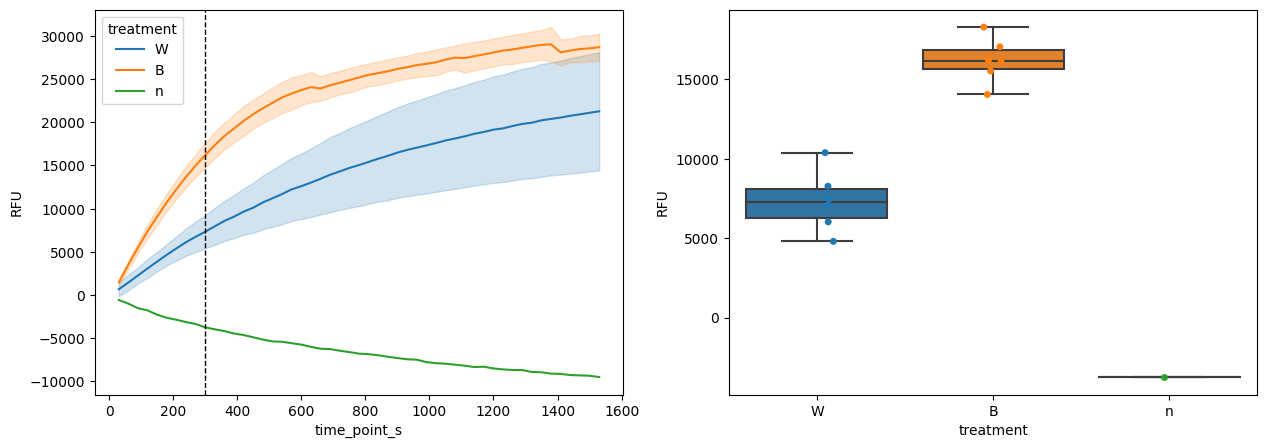

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.lineplot(data=casein_A, x='time_point_s', y='RFU', hue='treatment', ci='sd', ax=axes[0])
#sns.scatterplot(data=new, x='time_point_s', y='RFU', hue='treatment', ax=axes[0])
axes[0].axvline(time_point, ls='--', lw='1', color='black')

sns.boxplot(data=casein_A_5min, x='treatment', y='RFU', ax=axes[1])
sns.stripplot(data=casein_A_5min, x='treatment', y='RFU', ax=axes[1])

plt.show()

## Casein assay inhibitory cocktails S.lycopersicum

In [7]:
inh = pd.read_csv('/home/felix/thesis/chapter2_tomato_ISs/Results/1_Immuno_secretomes_of_tomatoes/casein/casein_inh_data.csv', skiprows=1)
inh.drop([0], inplace=True)
inh.index = inh.Time_s.to_numpy()
inh.drop(columns=['Time_s'], inplace=True)

In [59]:
new = []

#groups = np.unique(inh.index.to_numpy())
groups = ['noInhib', 'noAF', 'noCasein', 'E64', 'Phenanthroline', 'PepstatinA', 'PMSF', '34DCI', 'allInhib']
grouping = {'noAF':'noAF',
           'noCasein':'noCasein',
           'noInhib':'noInhibitor',
           'E64':'manual',
           'Phenantroline':'manual',
            'PepstatinA':'manual',
           'PMSF':'manual',
           '34DCI':'other',
           'allInhib':'InhibitorCocktail'}

#groups = ['noCasein']

for row in groups:
    for counter, col in enumerate(inh.columns):
        
        if counter == 0:
            base = inh.loc[row, col]

        else:
            tmp = inh.loc[row, col]
            name = np.unique(tmp.index.to_numpy())[0]
            tmp = tmp - base
               
            for reps in range(len(tmp)):
                new.append([name, float(col), tmp[reps]])

inh_A = pd.DataFrame(new, columns=['name', 'time_point_s', 'RFU'])

for i in np.unique(inh_A.time_point_s.to_numpy()):
    base = np.mean(inh_A[(inh_A.time_point_s == i) & (inh_A.name == 'noInhib')].RFU.to_numpy())
    
    for spec_inh in groups:
        tmp = inh_A[(inh_A.time_point_s == i) & (inh_A.name == spec_inh)]
        for row in tmp.index:
            inh_A.loc[row, 'perc_inhibition'] = 1 - (inh_A.loc[row, 'RFU']/base)

In [61]:
time_point = float(find_nearest(inh_A.time_point_s.to_numpy(), 300))

In [62]:
inh_A_5min = inh_A[inh_A.time_point_s == time_point]
for i in groups:
    tmp = inh_A_5min[inh_A_5min.name == i]
    
    for j in tmp.index:
        inh_A_5min.loc[j, 'percA'] = tmp.loc[j, 'RFU'] / np.mean(inh_A_5min[inh_A_5min.name == 'noInhib']['RFU'].to_numpy()) 
        inh_A_5min.loc[j, 'inhibition'] = 1 - inh_A_5min.loc[j, 'percA']


/home/felix/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/felix/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [63]:
no_inh = inh_A_5min[inh_A_5min.name == 'noInhib'].RFU.to_numpy()
e64 = inh_A_5min[inh_A_5min.name == 'E64'].RFU.to_numpy()
phenan = inh_A_5min[inh_A_5min.name == 'Phenanthroline'].RFU.to_numpy()
pepst = inh_A_5min[inh_A_5min.name == 'PepstatinA'].RFU.to_numpy()
pmsf = inh_A_5min[inh_A_5min.name == 'PMSF'].RFU.to_numpy()
dci = inh_A_5min[inh_A_5min.name == '34DCI'].RFU.to_numpy()
all_inh = inh_A_5min[inh_A_5min.name == 'allInhib'].RFU.to_numpy()

In [92]:
cond = [e64, phenan, pepst, pmsf, dci, all_inh]
name = ['e64', 'phenantroline', 'pepstatinA', 'PMSF', '34DCI', 'all_inh']

for i, j in zip(cond, name):
    print("{}:\t{}".format(j, 1-(np.mean(i)/np.mean(no_inh))))
    
tests = []

for i, j in zip(cond, name):
    t_t, t_p = scipy.ttest_ind(i, no_inh, alternative='less')
    tests.append(t_p)
    
print(multi.fdrcorrection(tests))
print(tests)

e64:	0.11002994011976053
phenantroline:	0.14071856287425144
pepstatinA:	0.062125748502993905
PMSF:	0.2043413173652695
34DCI:	0.15643712574850288
all_inh:	0.5134730538922156
(array([False, False, False, False, False,  True]), array([0.25331322, 0.15910787, 0.26595987, 0.15910787, 0.15910787,
       0.01781432]))
[0.21109435095706486, 0.10607191571936185, 0.2659598705800782, 0.08154286688977072, 0.10480122551115387, 0.0029690529886867334]


In [65]:
1 - (np.mean(e64)/np.mean(no_inh))

0.11002994011976053

In [66]:
inh_A.columns

Index(['name', 'time_point_s', 'RFU', 'perc_inhibition'], dtype='object')

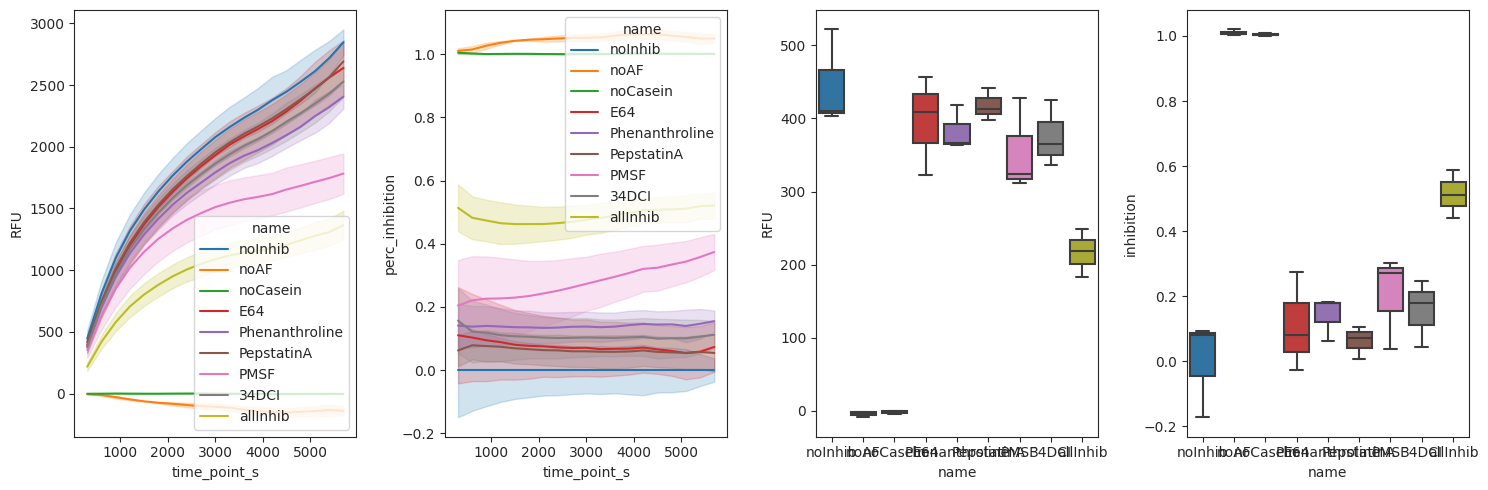

In [68]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

sns.lineplot(data=inh_A, x='time_point_s', y='RFU', hue='name', ci='sd', ax=axes[0])
sns.lineplot(data=inh_A, x='time_point_s', y='perc_inhibition', hue='name', ci='sd', ax=axes[1])

sns.boxplot(data=inh_A_5min, x='name', y='RFU', ax=axes[2])
sns.boxplot(data=inh_A_5min, x='name', y='inhibition', ax=axes[3])

plt.tight_layout()
plt.show()

In [12]:
np.unique(casein_A['sample'].to_numpy())

array(['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'W1', 'W2', 'W3', 'W4', 'W5',
       'W6', 'noAF'], dtype=object)

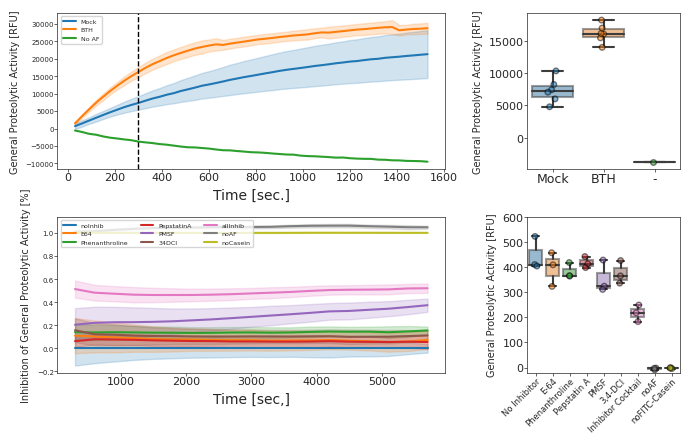

In [90]:
sns.set_style("ticks")

def annotate_axes(axes_list):
    for i, ax in enumerate(axes_list):
        ax.tick_params(axis='both', labelsize=8, pad=0.5)
        # change all spines
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(0.5)
        ax.xaxis.set_tick_params(width=0.5, length=2)
        ax.yaxis.set_tick_params(which='minor', width=0.25, length=2)
        ax.yaxis.set_tick_params(which='major', width=0.5, length=2)


figure = plt.figure(figsize=(7, 4.5))

Aser = plt.subplot2grid((2, 3), (0, 0), colspan=2)
Abar = plt.subplot2grid((2, 3), (0, 2))
Iser = plt.subplot2grid((2, 3), (1, 0), colspan=2)
Ibar = plt.subplot2grid((2, 3), (1, 2))

axes = [Aser, Abar, Iser, Ibar]
annotate_axes(axes)

### Define some arrays ###

inh_ser_order = ['noInhib', 'E64', 'Phenanthroline', 'PepstatinA', 'PMSF', '34DCI', 'allInhib', 'noAF', 'noCasein']
inh_order = ['noInhib', 'E64', 'Phenanthroline', 'PepstatinA', 'PMSF', '34DCI', 'allInhib', 'noAF', 'noCasein']
inh_labels = ['No Inhibitor', 'E-64', 'Phenanthroline', 'Pepstatin A', 'PMSF', '3,4-DCI', 'Inhibitor Cocktail', 'noAF', 'noFITC-Casein']

### Generate individual plots ###

# Casein activity time series

sns.lineplot(data=casein_A, x='time_point_s', y='RFU', hue='treatment', ci='sd', ax=Aser)
Aser.axvline(time_point, ls='--', lw='1', color='black')

Aser.set_xlabel('Time [sec.]', fontsize=10)
Aser.set_ylabel('General Proteolytic Activity [RFU]', fontsize=7)
Aser.tick_params(axis='y', labelsize=5)

handles, labels = Aser.get_legend_handles_labels()
Aser.legend(handles[:3], ['Mock', 'BTH', 'No AF'], ncol=1, loc=2, prop={"size":4.5}, markerscale=0.5)

# Casein activity 5 minute end point

sns.boxplot(data=casein_A_5min, x='treatment', y='RFU', boxprops={'alpha':0.5}, ax=Abar)
sns.stripplot(data=casein_A_5min, x='treatment', y='RFU', size=4, edgecolor='black', linewidth=1, alpha=0.5, ax=Abar)

Abar.set_xlabel('')
Abar.set_ylabel('General Proteolytic Activity [RFU]', fontsize=7)
Abar.set_xticklabels(['Mock', 'BTH', '-'], fontsize=9)


# Casein A with inhibitors series

#Iser.set_xlim(0, 1600)
sns.lineplot(data=inh_A, x='time_point_s', y='perc_inhibition', hue='name', hue_order=inh_ser_order, ci='sd', ax=Iser)

Iser.set_xlabel('Time [sec,]', fontsize=10)
Iser.set_ylabel('Inhibition of General Proteolytic Activity [%]', fontsize=7)
Iser.tick_params(axis='y', labelsize=5)


handles, labels = Iser.get_legend_handles_labels()
Iser.legend(handles, labels, ncol=3, loc=2, prop={"size":4.5}, markerscale=0.5)

# Casein A with inhibitors 5 min endpoint

Ibar.set_ylim(-20, 600)
#sns.boxplot(data=inh_A_5min[(inh_A_5min.name != 'noAF') & (inh_A_5min.name != 'noCasein')], x='name', y='RFU', boxprops={'alpha':0.5}, order=inh_order, ax=Ibar)
#sns.stripplot(data=inh_A_5min[(inh_A_5min.name != 'noAF') & (inh_A_5min.name != 'noCasein')], x='name', y='RFU', size=4, edgecolor='black', linewidth=1, alpha=0.5, order=inh_order, ax=Ibar)

sns.boxplot(data=inh_A_5min, x='name', y='RFU', boxprops={'alpha':0.5}, order=inh_order, ax=Ibar)
sns.stripplot(data=inh_A_5min, x='name', y='RFU', size=4, edgecolor='black', linewidth=1, alpha=0.5, order=inh_order, ax=Ibar)

Ibar.set_xlabel('')
Ibar.set_ylabel('General Proteolytic Activity [RFU]', fontsize=7)
Ibar.set_xticklabels(inh_labels, rotation=45, ha='right', rotation_mode="anchor", size=6)


# MDH activity

plt.tight_layout()
#plt.tight_layout(pad=0.75, h_pad=0.001)
plt.savefig('/home/felix/thesis/chapter2_tomato_ISs/Results/1_Immuno_secretomes_of_tomatoes/Figure2_jupyter.svg', transparent=True)
plt.show()